In [1]:
import numpy as np
import pandas as pd
from time import time
import itertools
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
google_W2V = 'GoogleNews-vectors-negative300.bin.gz'
TEST_CSV = "test.csv"
TRAIN_CSV = "train.csv"

def get_dataframe(path,chunksize):
    df = pd.read_csv(path,nrows=chunksize)
    return df

In [3]:
train_data=get_dataframe(TRAIN_CSV,10**5)
train_data.shape

(100000, 6)

In [4]:
test_data=get_dataframe(TEST_CSV,10**5)
test_data.shape

(100000, 3)

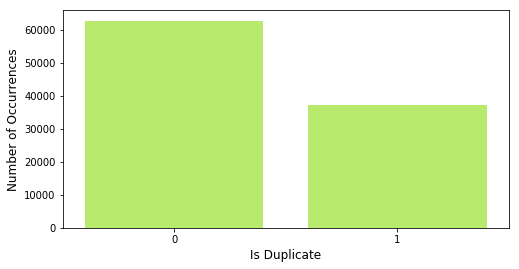

In [5]:
is_dup = train_data['is_duplicate'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color='greenyellow')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

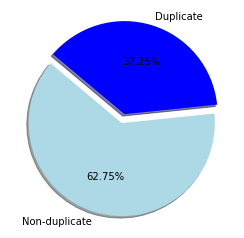

In [6]:
plt.figure(figsize=(4, 4))
plt.pie(train_data.is_duplicate.value_counts(), explode=(0.1, 0), labels=('Non-duplicate', 'Duplicate'), colors=('lightblue', 'blue'), autopct='%1.2f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()
del train_data
del test_data

In [7]:
#text analysis
import re
def text_to_word_list(text):
    text = str(text)
    text = text.lower()
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    return text





In [8]:
# Prepare embedding
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
vocabulary = dict()
inverse_vocabulary = []  
word2vec = KeyedVectors.load_word2vec_format(google_W2V, binary=True)

C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
#nltk 
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
questions_cols = ['question1', 'question2']

In [10]:
#Getting Dataframe
test_df = get_dataframe(TEST_CSV,10**5)
#pd.read_csv(TEST_CSV,nrows=chunksize)
train_df = get_dataframe(TRAIN_CSV,10**5)
#pd.read_csv(TRAIN_CSV,nrows=chunksize)


# train_df iteration
for index, row in train_df.iterrows():
    
    for question in questions_cols:
        corpus = []  
        for word in text_to_word_list(row[question]):

            
            if word in stops and word not in word2vec.vocab:
                continue

            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                corpus.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                corpus.append(vocabulary[word])

        
        train_df.set_value(index, question, corpus)

In [11]:
# test_df iteration
for index, row in test_df.iterrows():
    
    for question in questions_cols:
        corpus2 = []  
        for word in text_to_word_list(row[question]):

            
            if word in stops and word not in word2vec.vocab:
                continue

            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                corpus2.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                corpus2.append(vocabulary[word])

        
        test_df.set_value(index, question, corpus2)

In [12]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)
embeddings[0] = 0

for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

In [13]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

test_size = 40000
training_size = len(train_df) - test_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train = {'left': X_train.question1, 'right': X_train.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}
#X_test = {'left': test_df.question1, 'right': test_df.question2}

Y_train = Y_train.values
Y_test = Y_test.values

from keras.preprocessing.sequence import pad_sequences

for dataset, side in itertools.product([X_train, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

Using TensorFlow backend.


In [14]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adam

# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))


left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)


encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)


shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)


lstm_distance = Merge(mode=lambda x: distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])


lstm = Model([left_input, right_input], [lstm_distance])


optimizer = Adam(clipnorm=gradient_clipping_norm)

lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])


training_start_time = time()

lstm_trained = lstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_test['left'], X_test['right']], Y_test))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\HP\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:47: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 40000 samples
Epoch 1/25
60000/60000 [==============================] - 720s 12ms/step - loss: 0.1886 - acc: 0.7240 - val_loss: 0.1744 - val_acc: 0.7414
Epoch 2/25
60000/60000 [==============================] - 706s 12ms/step - loss: 0.1634 - acc: 0.7662 - val_loss: 0.1625 - val_acc: 0.7667
Epoch 3/25
60000/60000 [==============================] - 706s 12ms/step - loss: 0.1528 - acc: 0.7873 - val_loss: 0.1570 - val_acc: 0.7777
Epoch 4/25
60000/60000 [==============================] - 739s 12ms/step - loss: 0.1459 - acc: 0.7994 - val_loss: 0.1541 - val_acc: 0.7872
Epoch 5/25
60000/60000 [==============================] - 750s 12ms/step - loss: 0.1407 - acc: 0.8090 - val_loss: 0.1509 - val_acc: 0.7887
Epoch 6/25
60000/60000 [==============================] - 747s 12ms/step - loss: 0.1367 - acc: 0.8147 - val_loss: 0.1491 - val_acc: 0.7954
Epoch 7/25
60000/60000 [==============================] - 720s 12ms/step - loss: 0.1327 - acc: 0.8221 - val_loss: 0.

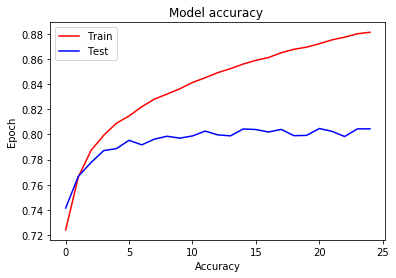

In [15]:

plt.plot(lstm_trained.history['acc'], color = 'red', label = 'Train')

plt.plot(lstm_trained.history['val_acc'], color = 'blue', label = 'Test')

plt.title('Model accuracy ')

plt.xlabel('Accuracy')

plt.ylabel('Epoch')

plt.legend()

plt.show()
